In [5]:
import os
import pandas as pd
import numpy as np
import gc
gc.collect()
os.listdir('Data')

# Load Data
dtype = {
    'ip': np.int32,
    'app': np.int16,
    'device': np.int16,
    'os': np.int16,
    'channel': np.int16,
    'click_time': str,
    'attributed_time': str,
    'is_attributed': np.uint8,
}

data = pd.read_csv('Data/train_sample.csv.zip',dtype=dtype,low_memory=True,parse_dates=['click_time','attributed_time'])
data.head(5)

data["day"] = data['click_time'].dt.day.astype('uint8')
data["hour"] = data['click_time'].dt.hour.astype('uint8')

data['click_time'] = (data['click_time'].astype(np.int64) // 10 ** 9).astype(np.int32)
data['cum_hour'] = (data.day - 6)*24 + data.hour

varcols = ['ip', 'app', 'device', 'os', 'channel',]
for v in varcols:
    data[v] = data[v].astype('category')
    #test[v]=test[v].astype('category')
data = data.drop(columns = ['attributed_time'])
del varcols
gc.collect()

80

In [2]:
groupby_cols = [
    #V1
    ['ip'], ['app'], ['device'], ['os'], ['channel'],
    
    #V2
    ['ip','app'],['ip','device'],['ip','os'],['ip','channel'],
    ['app', 'channel'],['app', 'os'],['app', 'device'],
    ['channel', 'os'],['channel', 'device'],
    ['os', 'device'],
    
    #V3
    ['ip', 'app', 'device'],['ip', 'app', 'os'],['ip', 'app', 'channel'],
    ['ip', 'device', 'os'],['ip', 'device', 'channel'],['ip','os','channel'],
    ['app','device','os'],['app','device','channel'],['app','os','channel'],
    ['device','os','channel'],
    
    #V4
    ['ip','app','device','os'],['ip','app','device','channel'],['ip','app','os','channel'],
    ['ip','device','os','channel'],['app','device','os','channel']
]

In [30]:
gb = data.groupby(['app', 'channel'])
counts = gb.size().to_frame(name='counts')
counts.join(gb.agg({'is_attributed':'mean'}).rename(columns = {'is_attributed':'is_attributed_mean'}))


counts  is_attributed_mean
app channel                            
1   13           67                 0.0
    17          115                 0.0
    18            1                 0.0
    24           30                 0.0
    30            1                 0.0
    101          60                 0.0
    113           1                 0.0
    115         143                 0.0
    118          59                 0.0
    120          14                 0.0
    124         129                 0.0
    125         206                 0.0
    134         648                 0.0
    135         248                 0.0
    137         131                 0.0
    150         105                 0.0
    153         501                 0.0
    178          89                 0.0
    182           1                 0.0
    213           1                 0.0
    317           2                 0.0
    349         141                 0.0
    371          14                 0.0
    377         201                 0.0
    439         119                 0.0
    452         106                 0.0
    460           2                 0.0
2   18           24                 0.0
    108           5                 0.0
    122         889                 0.0
...             ...                 ...
204 347           2                 0.0
208 113           1                 1.0
    330          12                 0.0
215 347           4                 0.0
216 213           1                 0.0
232 347           9                 0.0
233 347           1                 0.0
261 243           1                 1.0
266 347           2                 0.0
267 347           1                 0.0
268 347           1                 0.0
271 347           1                 0.0
273 347           3                 0.0
293 347           1                 0.0
302 347           1                 0.0
310 272           3                 0.0
315 110           4                 0.0
347 347           1                 0.0
363 347           2                 0.0
372 107           1                 0.0
394 347           2                 0.0
398 347           1                 0.0
407 347           1                 0.0
425 347           2                 0.0
474 272           1                 0.0
486 21            1                 0.0
536 21            1                 0.0
538 347           1                 0.0
548 347           1                 0.0
551 243           1                 0.0

[443 rows x 2 columns]

In [31]:
counts

counts
app channel        
1   13           67
    17          115
    18            1
    24           30
    30            1
    101          60
    113           1
    115         143
    118          59
    120          14
    124         129
    125         206
    134         648
    135         248
    137         131
    150         105
    153         501
    178          89
    182           1
    213           1
    317           2
    349         141
    371          14
    377         201
    439         119
    452         106
    460           2
2   18           24
    108           5
    122         889
...             ...
204 347           2
208 113           1
    330          12
215 347           4
216 213           1
232 347           9
233 347           1
261 243           1
266 347           2
267 347           1
268 347           1
271 347           1
273 347           3
293 347           1
302 347           1
310 272           3
315 110           4
347 347           1
363 347           2
372 107           1
394 347           2
398 347           1
407 347           1
425 347           2
474 272           1
486 21            1
536 21            1
538 347           1
548 347           1
551 243           1

[443 rows x 1 columns]

In [27]:
k = data.groupby(['app', 'channel']).agg({'is_attributed':['mean','count']}).reset_index()
k.head()

app channel is_attributed      
                       mean count
0   1      13           0.0    67
1   1      17           0.0   115
2   1      18           0.0     1
3   1      24           0.0    30
4   1      30           0.0     1

In [15]:
data[(data.app == 1) & (data.channel ==13)].shape

(67, 40)

In [13]:
#data.to_csv('time_added.csv',index = False)

In [6]:
from tqdm import tqdm
def rate_calculation(x):
        """Calculate the attributed rate. Scale by confidence"""
        rate = x.sum() / float(x.count())
        #conf = np.min([1, np.log(x.count()) / log_group])
        return rate# * conf
for cols in tqdm(groupby_cols):
    new_feature = '_'.join(cols) + '_CovRate'
    group_object = data.groupby(cols)
    data = data.merge(
        group_object['is_attributed'].apply(rate_calculation).reset_index(). \
        rename(index=str,columns={'is_attributed': new_feature})[cols + [new_feature]],on=cols, how='left')
    
data.head()

  0%|          | 0/30 [00:00<?, ?it/s]

ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'

Exception ignored in: 'pandas._libs.lib.is_bool_array'
ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'


ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'

Exception ignored in: 'pandas._libs.lib.is_bool_array'
ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'


ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'

Exception ignored in: 'pandas._libs.lib.is_bool_array'
ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'


ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'

Exception ignored in: 'pandas._libs.lib.is_bool_array'
ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'


ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'

Exception ignored in: 'pandas._libs.lib.is_bool_array'
ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'
  3%|▎         | 1/30 [00:04<02:19,  4.80s/it]

ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'

Exception ignored in: 'pandas._libs.lib.is_bool_array'
ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'


ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'

Exception ignored in: 'pandas._libs.lib.is_bool_array'
ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'


ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'

Exception ignored in: 'pandas._libs.lib.is_bool_array'
ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'


ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'

Exception ignored in: 'pandas._libs.lib.is_bool_array'
ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'


ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'

Exception ignored in: 'pandas._libs.lib.is_bool_array'
ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'


ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'

Exception ignored in: 'pandas._libs.lib.is_bool_array'
ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'


ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'

Exception ignored in: 'pandas._libs.lib.is_bool_array'
ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'


ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'

Exception ignored in: 'pandas._libs.lib.is_bool_array'
ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'


ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'

Exception ignored in: 'pandas._libs.lib.is_bool_array'
ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'


ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'

Exception ignored in: 'pandas._libs.lib.is_bool_array'
ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'
 10%|█         | 3/30 [00:04<00:44,  1.64s/it]

ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'

Exception ignored in: 'pandas._libs.lib.is_bool_array'
ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'


ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'

Exception ignored in: 'pandas._libs.lib.is_bool_array'
ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'


ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'

Exception ignored in: 'pandas._libs.lib.is_bool_array'
ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'


ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'

Exception ignored in: 'pandas._libs.lib.is_bool_array'
ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'


ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'

Exception ignored in: 'pandas._libs.lib.is_bool_array'
ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'


ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'

Exception ignored in: 'pandas._libs.lib.is_bool_array'
ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'


ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'

Exception ignored in: 'pandas._libs.lib.is_bool_array'
ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'


ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'

Exception ignored in: 'pandas._libs.lib.is_bool_array'
ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'


ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'

Exception ignored in: 'pandas._libs.lib.is_bool_array'
ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'


ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'

Exception ignored in: 'pandas._libs.lib.is_bool_array'
ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'
 17%|█▋        | 5/30 [00:05<00:25,  1.01s/it]

ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'

Exception ignored in: 'pandas._libs.lib.is_bool_array'
ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'


ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'

Exception ignored in: 'pandas._libs.lib.is_bool_array'
ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'


ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'

Exception ignored in: 'pandas._libs.lib.is_bool_array'
ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'
 20%|██        | 6/30 [00:15<01:03,  2.64s/it]

ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'

Exception ignored in: 'pandas._libs.lib.is_bool_array'
ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'


ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'

Exception ignored in: 'pandas._libs.lib.is_bool_array'
ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'
 23%|██▎       | 7/30 [00:21<01:09,  3.00s/it]

ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'

Exception ignored in: 'pandas._libs.lib.is_bool_array'
ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'
100%|██████████| 30/30 [02:53<00:00,  5.78s/it]


,ip,app,device,os,channel,click_time,is_attributed,day,hour,cum_hour,...,ip_os_channel_CovRate,app_device_os_CovRate,app_device_channel_CovRate,app_os_channel_CovRate,device_os_channel_CovRate,ip_app_device_os_CovRate,ip_app_device_channel_CovRate,ip_app_os_channel_CovRate,ip_device_os_channel_CovRate,app_device_os_channel_CovRate
0,87540,12,1,13,497,1510047038,0,7,9,33,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,105560,25,1,17,259,1510062027,0,7,13,37,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,101424,12,1,19,212,1510077924,0,7,18,42,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,94584,13,1,13,477,1510030688,0,7,4,28,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,68413,12,1,1,178,1510218009,0,9,9,81,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [13]:
pd.options.display.max_columns = 100
data[data.app_CovRate==1]

,ip,app,device,os,channel,click_time,is_attributed,day,hour,cum_hour,ip_CovRate,app_CovRate,device_CovRate,os_CovRate,channel_CovRate,ip_app_CovRate,ip_device_CovRate,ip_os_CovRate,ip_channel_CovRate,app_channel_CovRate,app_os_CovRate,app_device_CovRate,channel_os_CovRate,channel_device_CovRate,os_device_CovRate,ip_app_device_CovRate,ip_app_os_CovRate,ip_app_channel_CovRate,ip_device_os_CovRate,ip_device_channel_CovRate,ip_os_channel_CovRate,app_device_os_CovRate,app_device_channel_CovRate,app_os_channel_CovRate,device_os_channel_CovRate,ip_app_device_os_CovRate,ip_app_device_channel_CovRate,ip_app_os_channel_CovRate,ip_device_os_channel_CovRate,app_device_os_channel_CovRate
3914,220571,71,1,25,3,1510115721,1,8,4,52,1.000000,1.0,0.001548,0.002224,0.004098,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.090909,0.004819,0.002294,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.090909,1.0,1.0,1.0,1.0,1.0
5111,303875,71,1,19,3,1510240428,1,9,15,87,1.000000,1.0,0.001548,0.001718,0.004098,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.008130,0.004819,0.001714,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.008850,1.0,1.0,1.0,1.0,1.0
37850,346860,145,50,0,320,1510232616,1,9,13,85,1.000000,1.0,0.250000,0.130653,0.058824,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.200000,1.000000,0.250000,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.000000,1.0,1.0,1.0,1.0,1.0
41993,35308,96,0,0,213,1510102491,1,8,0,48,0.083333,1.0,0.096118,0.130653,0.173077,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.194805,0.163043,0.118750,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.200000,1.0,1.0,1.0,1.0,1.0
90568,179080,116,1,35,101,1510029020,1,7,4,28,1.000000,1.0,0.001548,0.001094,0.011017,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.090909,0.011310,0.001134,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.090909,1.0,1.0,1.0,1.0,1.0
93842,346361,115,1,22,203,1510240450,1,9,15,87,1.000000,1.0,0.001548,0.001486,0.166667,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.500000,0.166667,0.001529,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.500000,1.0,1.0,1.0,1.0,1.0
95484,288079,261,0,0,243,1510219385,1,9,9,81,1.000000,1.0,0.096118,0.130653,0.024272,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.000000,0.500000,0.118750,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.000000,1.0,1.0,1.0,1.0,1.0


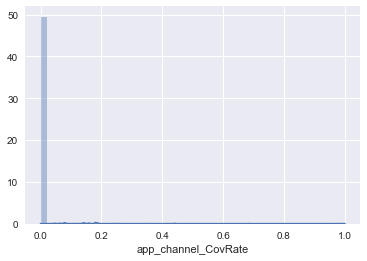

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(color_codes=True)
sns.distplot(data.app_channel_CovRate)

In [20]:
data.isna().any()

ip                               False
app                              False
device                           False
os                               False
channel                          False
click_time                       False
is_attributed                    False
day                              False
hour                             False
cum_hour                         False
ip_CovRate                       False
app_CovRate                      False
device_CovRate                   False
os_CovRate                       False
channel_CovRate                  False
ip_app_CovRate                   False
ip_device_CovRate                False
ip_os_CovRate                    False
ip_channel_CovRate               False
app_channel_CovRate              False
app_os_CovRate                   False
app_device_CovRate               False
channel_os_CovRate               False
channel_device_CovRate           False
os_device_CovRate                False
ip_app_device_CovRate    